In [1]:
!pip install pyforest
from pyforest import *
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
import datetime, pickle, copy, warnings
from pandas import DataFrame, concat
import seaborn
import glob
import pandas.testing as tm
from functools import reduce
from pandas import DataFrame, merge, concat
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from joblib import Parallel, delayed
import seaborn as sns
import time
from sklearn.preprocessing import MaxAbsScaler
import scipy.linalg
import decimal
!pip install scikit-plot
import scikitplot
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import matplotlib.ticker as mtick
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from yellowbrick.classifier import ClassificationReport
from sklearn.decomposition import PCA, KernelPCA
from numpy import where, meshgrid, arange, hstack
from mlxtend.plotting import plot_decision_regions
from sklearn.manifold import TSNE
from sklearn.decomposition import MiniBatchDictionaryLearning
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import plotly.express as px
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedStratifiedKFold, cross_val_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV,SelectPercentile,mutual_info_classif, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from numpy import mean, std
!pip install tscv

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
df = pd.read_csv("july_futures_1min.csv")
df.set_index('timestamp', inplace=True)
df.sort_index(ascending=True, inplace=True)
df.index = pd.to_datetime(df.index)

d = df.copy()
periods = 1
#Classification
d['SP_frwd_ret'] = (d['es_close']/d['es_open']).shift(-periods) -1

#Classification
#d['SP_frwd_ret'] = (d['es_close'].shift(-periods) - d['es_close']) / d['es_close']

# If next period's return > 0, then 1, if next period's return <= 0, then 0
d['y'] = 0
# setting target as binary 
requirement = 0
def getBinary(val):
    if val>=requirement:
        return 1
    else:
        return -1

d['y'] = d.SP_frwd_ret.apply(getBinary) # target
d.drop(['SP_frwd_ret', 'es_rets','es_open','es_high','es_low'], 1, inplace=True)
print('Original data shape:', d.shape); print()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Original data shape: (31985, 93)



In [3]:
#Split data set
x = d.loc[:, d.columns != 'y']
y = d.loc[:, d.columns == 'y']

In [4]:
x.columns

Index(['es_close', 'es_close_open', 'es_countg', 'es_countp', 'es_weightedpricep', 'es_weightedpriceg', 'es_amountp', 'es_amountg', 'gc_close',
       'gc_countg', 'gc_countp', 'gc_weightedpricep', 'gc_weightedpriceg', 'gc_amountp', 'gc_amountg', '6E_close', '6E_countp', '6E_countg',
       '6E_amountp', '6E_amountg', '6E_weightedpricep', '6E_weightedpriceg', '6J_close', '6J_countp', '6J_countg', '6J_amountp', '6J_amountg',
       '6J_weightedpricep', '6J_weightedpriceg', 'CL_close', 'CL_countp', 'CL_countg', 'CL_amountp', 'CL_amountg', 'CL_weightedpricep',
       'CL_weightedpriceg', 'NQ_close', 'NQ_countp', 'NQ_countg', 'NQ_amountp', 'NQ_amountg', 'NQ_weightedpricep', 'NQ_weightedpriceg', 'SI_close',
       'SI_countp', 'SI_countg', 'SI_amountp', 'SI_amountg', 'SI_weightedpricep', 'SI_weightedpriceg', 'TN_close', 'TN_countp', 'TN_countg',
       'TN_amountp', 'TN_amountg', 'TN_weightedpricep', 'TN_weightedpriceg', 'YM_close', 'YM_countp', 'YM_countg', 'YM_amountp', 'YM_amountg',
    

In [5]:
#Initialize and fit scaler
scaler = StandardScaler()
#Fit scaler using the training data
scaler.fit(x)

#Transform the raw data
xScaled = scaler.transform(x)

In [7]:
# FEATURE SELECTION
#1
MiSelect = SelectPercentile(mutual_info_classif, 
                             percentile=60).fit(xScaled, np.ravel(y.values))
# remove lower 40%
xMi = MiSelect.transform(xScaled)
print("Feature Selection Results:")
print("Filter Result:"); print("Number of features: ", xMi.shape[1])

<IPython.core.display.Javascript object>

Feature Selection Results:
Filter Result:
Number of features:  55


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Correlation Filter Result:
Number of features:  43


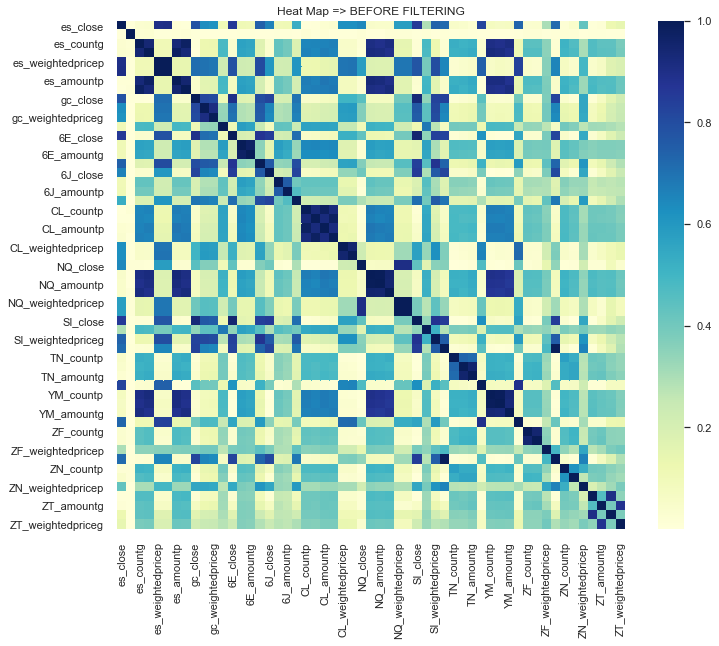

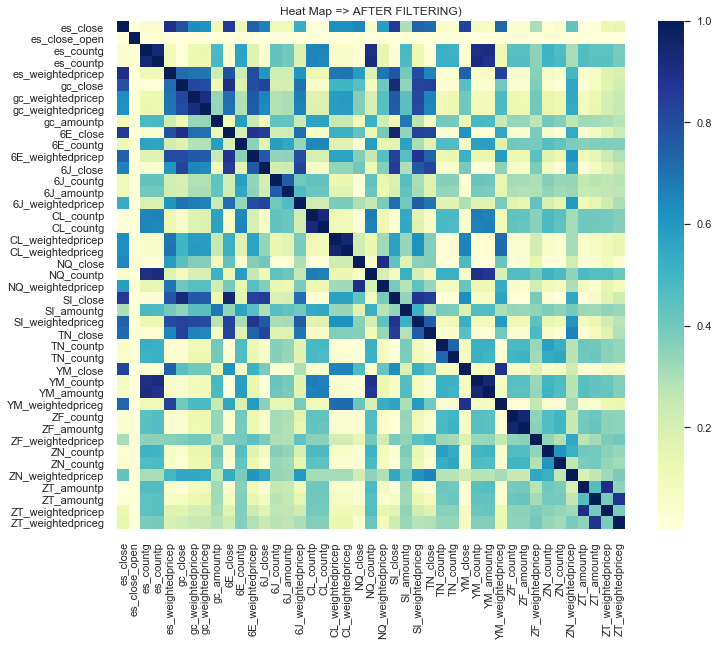

In [12]:
#2
# Corr_threshold is the cuttoff level for correlation coefficient
def correlation(x, corr_threshold):
    corr = x.corr(method = "spearman").abs()
    
    """Spearman’s correlation is non-parametric and does not assume a linear relationship between variables; 
    it looks for monotonic relationships"""

    upper = corr.where(np.triu(np.ones(corr.shape), k = 1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    x_corr_filtered = x.drop(to_drop, axis = 1)
    return x_corr_filtered

def heat_map(corr,title):
    sns.set(font_scale = 1.0)
    f, ax = plt.subplots(figsize=(11, 9))
    sns.heatmap(corr, cmap= "YlGnBu", square=True, ax = ax)
    f.tight_layout()
    ax.set_title(title)

mi = DataFrame(xMi,
                     index = x.index,
                     columns = x.columns[MiSelect.get_support()])

x_corr = correlation(mi, 0.95)

"""Spearman correlation coefficient is based on the ranked values for each variable""" 
corr_before = mi.corr(method = "spearman").abs()
corr_after = x_corr.corr(method = "spearman").abs()

heat_map(corr_before, "Heat Map => BEFORE FILTERING")
heat_map(corr_after, "Heat Map => AFTER FILTERING)")

print("Correlation Filter Result:")
print("Number of features: ", x_corr.shape[1])

<IPython.core.display.Javascript object>

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [99.0%] explained variance using the [43] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [34] that covers the [99.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


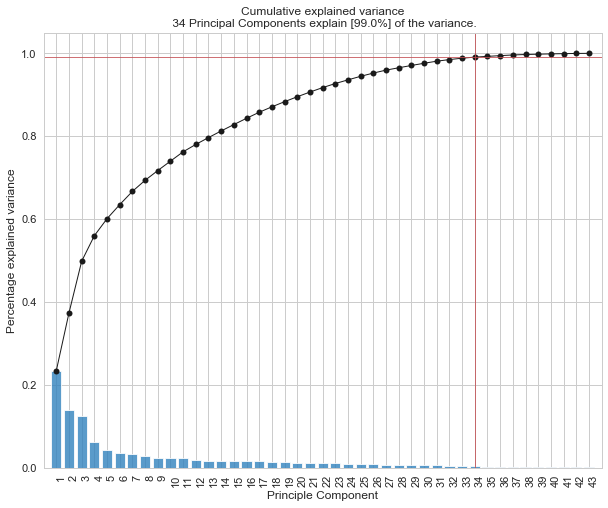

[0.23384655 0.13950317 0.12462486 0.06170353 0.04107875 0.03392118
 0.03199242 0.0266893  0.02357385 0.02277117 0.02255858 0.0177694
 0.01652744 0.01602339 0.01540023 0.01515889 0.01456713 0.01313519
 0.01243353 0.01189188 0.01130779 0.01073582 0.0098533  0.0088739
 0.00860804 0.00780113 0.00712468 0.00566293 0.00554528 0.00534054
 0.0050109  0.00389382 0.00336223 0.00254352]

Reduced dimensions can explain 0.9908 % of the variance in the original data

34



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

       0                  1
0    PC0          YM_countp
1    PC1           SI_close
2    PC2  NQ_weightedpricep
3    PC3         ZF_amountg
4    PC4         6J_amountp
5    PC5           YM_close
6    PC6          CL_countg
7    PC7  ZT_weightedpricep
8    PC8      es_close_open
9    PC9         ZT_amountp
10  PC10         gc_amountp
11  PC11          ZF_countg
12  PC12  gc_weightedpriceg
13  PC13  ZT_weightedpriceg
14  PC14  ZT_weightedpricep
15  PC15  6J_weightedpricep
16  PC16  ZF_weightedpricep
17  PC17         ZT_amountg
18  PC18          6E_countg
19  PC19          ZN_countg
20  PC20  SI_weightedpriceg
21  PC21           NQ_close
22  PC22  SI_weightedpriceg
23  PC23  6E_weightedpricep
24  PC24          ZN_countg
25  PC25         gc_amountp
26  PC26          TN_countg
27  PC27         ZF_amountg
28  PC28  CL_weightedpriceg
29  PC29           TN_close
30  PC30  gc_weightedpricep
31  PC31          6J_countg
32  PC32          NQ_countp
33  PC33           6J_close



<Figure size 576x396 with 0 Axes>

In [14]:
#3
#PCA

from pca import pca
plt.style.use('seaborn-whitegrid')
# Initialize to reduce the data up to the number of componentes that explains 99% of the variance.
model = pca(n_components = 0.99)
# Fit transform
x_pca = model.fit_transform(x_corr)
# Plot explained variance
fig, ax = model.plot()

tot_var = 0.99 # total variance
x_pca = PCA(tot_var, svd_solver = 'full').fit(x_corr)
print(x_pca.explained_variance_ratio_); print()
print("Reduced dimensions can explain {:.4f}".format(sum(x_pca.explained_variance_ratio_)),
      "% of the variance in the original data"); print()
print(x_pca.components_.shape[0]); print()
# number of components
n_pcs= x_pca.components_.shape[0]
# get the index of the most important feature on EACH component
most_important = [np.abs(x_pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = x_corr.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
p= DataFrame(dic.items())
print(p); print()

pca = PCA(tot_var, svd_solver = 'full')
x_pca = pca.fit_transform(x_corr)